# **NEURA: Neurodevelopmental Encryption & Unified Response for Autism**

An AI-powered autism detection system with built-in security features, ensuring privacy, encrypted data storage, and role-based access control for doctors, patients, and researchers.

#Cell 1: Install Required Libraries and Dependencies


In [1]:
# -*- coding: utf-8 -*-
# Install necessary Python packages
!pip install pandas numpy scikit-learn matplotlib seaborn gradio cryptography pymongo bcrypt

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib
import gradio as gr
import os
import json
import bcrypt
import uuid
import datetime
import base64
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC

# Set random seed for reproducibility
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00


#Cell 2: SecurityManager Class (Authentication & Encryption)


In [2]:
class SecurityManager:
    """
    Manages security aspects including user authentication, data encryption, and access control
    Ensures sensitive patient data is protected and only accessible to authorized roles
    """
    def __init__(self):
        # Initialize encryption key for securing data
        self.generate_key()
        # Define a simple user database with usernames, hashed passwords, roles, and names
        self.users_db = {
            "doctor_1": {"password": self.hash_password("doctor123"), "role": "doctor", "name": "Dr. Smith"},
            "patient_1": {"password": self.hash_password("patient123"), "role": "patient", "name": "John Doe", "patient_id": "P001"},
            "researcher_1": {"password": self.hash_password("researcher123"), "role": "researcher", "name": "Dr. Johnson"},
            "admin": {"password": self.hash_password("admin123"), "role": "admin", "name": "Admin User"}
        }
        # Define permissions for each role to enforce access control
        self.permissions = {
            "doctor": ["view_patient_data", "input_data", "run_model", "view_results"],
            "patient": ["view_own_results"],
            "researcher": ["view_anonymized_data", "run_analysis"],
            "admin": ["view_patient_data", "input_data", "run_model", "view_results", "view_anonymized_data", "run_analysis", "manage_users"]
        }
        # Initialize an empty dictionary to store encrypted patient records
        self.patient_records = {}

    def generate_key(self):
        """Generate a secure encryption key using a password and salt"""
        password = b"autisense_secure_key"  # Base password for key derivation
        salt = b"autisense_salt"  # Fixed salt for consistency
        kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=32, salt=salt, iterations=100000)  # Key derivation function
        key = base64.urlsafe_b64encode(kdf.derive(password))  # Derive and encode the key
        self.cipher_suite = Fernet(key)  # Initialize Fernet encryption with the key

    def hash_password(self, password):
        """Hash a password using bcrypt for secure storage"""
        return bcrypt.hashpw(password.encode('utf-8'), bcrypt.gensalt()).decode('utf-8')

    def verify_password(self, stored_hash, provided_password):
        """Verify if a provided password matches the stored hash"""
        return bcrypt.checkpw(provided_password.encode('utf-8'), stored_hash.encode('utf-8'))

    def authenticate(self, username, password):
        """Authenticate a user by checking their credentials"""
        if username in self.users_db and self.verify_password(self.users_db[username]["password"], password):
            return True, self.users_db[username]["role"]  # Return success and role
        return False, None  # Authentication failed

    def has_permission(self, role, permission):
        """Check if a role has a specific permission"""
        return role in self.permissions and permission in self.permissions[role]

    def encrypt_data(self, data):
        """Encrypt sensitive data (strings, numbers, dictionaries, or DataFrames)"""
        if isinstance(data, str):
            return self.cipher_suite.encrypt(data.encode('utf-8')).decode('utf-8')
        elif isinstance(data, (int, float)):
            return self.cipher_suite.encrypt(str(data).encode('utf-8')).decode('utf-8')
        elif isinstance(data, dict):
            return {key: self.encrypt_data(value) for key, value in data.items()}
        elif isinstance(data, pd.DataFrame):
            df_copy = data.copy()
            sensitive_cols = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
                              'Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD']
            for col in sensitive_cols:
                if col in df_copy.columns:
                    df_copy[col] = df_copy[col].apply(self.encrypt_data)
            return df_copy
        return data

    def decrypt_data(self, encrypted_data):
        """Decrypt previously encrypted data"""
        if isinstance(encrypted_data, str):
            try:
                return self.cipher_suite.decrypt(encrypted_data.encode('utf-8')).decode('utf-8')
            except:
                return encrypted_data  # Return as-is if decryption fails
        elif isinstance(encrypted_data, dict):
            return {key: self.decrypt_data(value) for key, value in encrypted_data.items()}
        elif isinstance(encrypted_data, pd.DataFrame):
            df_copy = encrypted_data.copy()
            sensitive_cols = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
                              'Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD']
            for col in sensitive_cols:
                if col in df_copy.columns:
                    df_copy[col] = df_copy[col].apply(self.decrypt_data)
            return df_copy
        return encrypted_data

    def add_patient_record(self, patient_id, data, result):
        """Add a new patient record with encrypted data"""
        record_id = str(uuid.uuid4())  # Generate a unique ID for the record
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Record creation time
        encrypted_data = self.encrypt_data(data)  # Encrypt sensitive data
        self.patient_records[record_id] = {
            "patient_id": patient_id,
            "data": encrypted_data,
            "result": result,
            "timestamp": timestamp
        }
        return record_id

    def get_patient_record(self, record_id):
        """Retrieve and decrypt a specific patient record by ID"""
        if record_id in self.patient_records:
            record = self.patient_records[record_id].copy()
            record["data"] = self.decrypt_data(record["data"])
            return record
        return None

    def get_patient_records_by_patient_id(self, patient_id):
        """Retrieve and decrypt all records for a specific patient"""
        patient_records = []
        for record_id, record in self.patient_records.items():
            if record["patient_id"] == patient_id:
                decrypted_record = record.copy()
                decrypted_record["data"] = self.decrypt_data(record["data"])
                decrypted_record["record_id"] = record_id
                patient_records.append(decrypted_record)
        return patient_records

    def save_patient_records(self, filename="patient_records.json"):
        """Save patient records to a JSON file for persistence"""
        with open(filename, 'w') as f:
            json.dump(self.patient_records, f)

    def load_patient_records(self, filename="patient_records.json"):
        """Load patient records from a JSON file"""
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                self.patient_records = json.load(f)

#Cell 3: PrivacyManager Class (Anonymization & Perturbation)


In [3]:
class PrivacyManager:
    """
    Manages data privacy by anonymizing and perturbing sensitive information
    Implements differential privacy to protect individual data points
    """
    def __init__(self):
        self.epsilon = 0.5  # Privacy budget for differential privacy (lower = more privacy)

    def anonymize_data(self, data):
        """Remove direct identifiers from data to anonymize it"""
        if isinstance(data, pd.DataFrame):
            df_copy = data.copy()
            identifiers = ['patient_id', 'name', 'address', 'phone', 'email']  # Columns to remove
            for col in identifiers:
                if col in df_copy.columns:
                    df_copy = df_copy.drop(columns=[col])
            return df_copy
        return data

    def perturb_data(self, data):
        """
        Add noise to numerical data using the Laplace mechanism for differential privacy
        Protects sensitive values while preserving overall trends
        """
        if isinstance(data, pd.DataFrame):
            df_copy = data.copy()
            numerical_cols = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Age_Mons']
            for col in numerical_cols:
                if col in df_copy.columns and pd.api.types.is_numeric_dtype(df_copy[col]):
                    sensitivity = 1.0  # Sensitivity for binary features (assumed)
                    scale = sensitivity / self.epsilon  # Noise scale based on privacy budget
                    noise = np.random.laplace(0, scale, size=len(df_copy))  # Generate Laplace noise
                    df_copy[col] = df_copy[col] + noise
                    if col.startswith('A'):  # Clip A1-A10 to valid range (0-1)
                        df_copy[col] = df_copy[col].clip(0, 1)
                    elif col == 'Age_Mons':  # Ensure Age_Mons is non-negative
                        df_copy[col] = df_copy[col].clip(0)
            return df_copy
        return data

    def generate_research_dataset(self, original_data, num_samples=None):
        """
        Create a privacy-preserving dataset for research by anonymizing and perturbing data
        Optionally samples a subset of records
        """
        anonymized_data = self.anonymize_data(original_data)
        perturbed_data = self.perturb_data(anonymized_data)
        if num_samples and num_samples < len(perturbed_data):
            sampled_data = perturbed_data.sample(n=num_samples, random_state=42)  # Randomly sample records
            return sampled_data
        return perturbed_data

#Cell 4: Data Loading and Preprocessing

In [4]:
def load_and_preprocess_data():
    """
    Load a dataset from a CSV file and preprocess it for model training
    Handles missing values, encodes categorical features, and scales numerical features
    """
    print("Please upload your dataset file:")  # Prompt user to upload a CSV
    uploaded = files.upload()  # Upload file in Colab
    file_name = list(uploaded.keys())[0]  # Get the uploaded file name
    df = pd.read_csv(file_name)  # Load dataset into a DataFrame
    print("Dataset loaded successfully!")

    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    numeric_cols = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Age_Mons']  # Numerical features
    categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who completed the test']  # Categorical features

    # Handle missing values
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())  # Fill numeric NaNs with column means
    df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))  # Fill categorical NaNs with mode

    # Standardize categorical column values
    df['Who completed the test'] = df['Who completed the test'].str.strip().str.lower()  # Normalize text

    # Encode categorical features into numerical values
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()  # Create a label encoder for each column
        df[col] = le.fit_transform(df[col].astype(str))  # Convert strings to integers
        label_encoders[col] = le  # Store encoder for later use

    # Prepare features (X) and target (y)
    features_to_drop = ['Case_No', 'Qchat-10-Score']  # Columns to exclude from features
    if all(col in df.columns for col in features_to_drop + ['Class/ASD Traits']):
        X = df.drop(columns=features_to_drop + ['Class/ASD Traits'])  # Features excluding target and unnecessary columns
        y = df['Class/ASD Traits'].map({'Yes': 1, 'No': 0})  # Target as binary (1=Yes, 0=No)
    else:
        cols_to_drop = [col for col in features_to_drop if col in df.columns]  # Adapt to available columns
        if 'Class/ASD Traits' in df.columns:
            cols_to_drop.append('Class/ASD Traits')
            X = df.drop(columns=cols_to_drop)
            y = df['Class/ASD Traits'].map({'Yes': 1, 'No': 0})
        else:
            X = df.drop(columns=cols_to_drop)
            y = None  # No target column found
            print("Warning: Target column 'Class/ASD Traits' not found. Model training will be skipped.")

    # Scale numerical features to have zero mean and unit variance
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Return preprocessed data, encoders, and scaler for model training and prediction
    return X, y, label_encoders, scaler, numeric_cols, categorical_cols, df

#Cell 5: Model Training and Evaluation Functions


In [5]:
def plot_feature_importance(model, feature_names):
    """Visualize the importance of features in a tree-based model"""
    if hasattr(model, 'feature_importances_'):  # Check if model supports feature importance
        importances = model.feature_importances_  # Get feature importance scores
        sorted_idx = np.argsort(importances)  # Sort features by importance
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), importances[sorted_idx])  # Horizontal bar plot
        plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])  # Label y-axis with feature names
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance in Model')
        plt.tight_layout()
        plt.show()

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate a model's performance with comprehensive metrics and visualizations"""
    y_pred = model.predict(X_test)  # Predict on test data
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Print key performance metrics
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    print("Average Precision:", np.mean(precision))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

def train_and_compare_models(X_train, X_test, y_train, y_test):
    """Train and compare multiple machine learning models"""
    # Define a dictionary of models to evaluate
    models = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "SVM": SVC(random_state=42, probability=True),
        "Random Forest": RandomForestClassifier(random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "AdaBoost": AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            learning_rate=1.0,
            random_state=42
        )
    }

    results = {}  # Store accuracy scores for each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)  # Train the model
        y_pred = model.predict(X_test)  # Predict on test set
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        results[model_name] = accuracy
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
        print(f"Cross-validation scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        evaluate_model(model, X_test, y_test, model_name)  # Detailed evaluation

    return models, results

def optimize_adaboost(X_train, y_train):
    """Optimize AdaBoost hyperparameters using grid search"""
    param_grid = {
        'n_estimators': [50, 100, 200],  # Number of estimators to test
        'learning_rate': [0.01, 0.1, 1.0],  # Learning rates to test
        'estimator__max_depth': [1, 2, 3]  # Decision tree depths (corrected syntax)
    }

    base_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy')  # 5-fold CV grid search
    grid_search.fit(X_train, y_train)  # Run grid search

    print("\nBest AdaBoost parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    return grid_search.best_estimator_  # Return the best model

def plot_model_comparison(results):
    """Plot a bar chart comparing model accuracies"""
    plt.figure(figsize=(12, 6))
    models = list(results.keys())
    accuracies = list(results.values())
    plt.bar(models, accuracies, color='skyblue', edgecolor='black')
    plt.title('Model Comparison: Accuracy Scores', fontsize=16)
    plt.xlabel('Models', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def train_best_model(X_train, X_test, y_train, y_test):
    """Execute the full model training pipeline and return the best model"""
    print("\nTraining and comparing multiple models...")
    models, results = train_and_compare_models(X_train, X_test, y_train, y_test)  # Compare models

    print("\nPlotting model comparison...")
    plot_model_comparison(results)  # Visualize comparison

    print("\nOptimizing AdaBoost model...")
    best_adaboost = optimize_adaboost(X_train, y_train)  # Optimize AdaBoost

    print("\nEvaluating optimized AdaBoost model...")
    evaluate_model(best_adaboost, X_test, y_test, "Optimized AdaBoost")  # Evaluate best model

    print("\nPlotting feature importance for optimized AdaBoost...")
    plot_feature_importance(best_adaboost, X_train.columns)  # Show feature importance

    return best_adaboost  # Return the optimized AdaBoost model

#Cell 6: Initialize UI and Launch Gradio


In [6]:
class AutiSenseUI:
    """
    Manages the Gradio user interface for interacting with the autism detection system
    Provides tabs for assessment, patient results, and research data access
    """
    def __init__(self, model, scaler, label_encoders, security_manager, privacy_manager,
                 numeric_cols, categorical_cols):
        self.model = model  # Trained ML model
        self.scaler = scaler  # Scaler for numerical features
        self.label_encoders = label_encoders  # Encoders for categorical features
        self.security_manager = security_manager  # Security manager instance
        self.privacy_manager = privacy_manager  # Privacy manager instance
        self.numeric_cols = numeric_cols  # List of numerical columns
        self.categorical_cols = categorical_cols  # List of categorical columns
        self.current_user = None  # Current logged-in user
        self.current_role = None  # Current user's role

    def login(self, username, password):
        """Handle user login and set current user/role"""
        success, role = self.security_manager.authenticate(username, password)
        if success:
            self.current_user = username
            self.current_role = role
            user_info = self.security_manager.users_db[username]
            return f"Login successful! Welcome, {user_info['name']} (Role: {role.capitalize()})"
        return "Login failed. Invalid username or password."

    def predict_autism(self, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, Age_Mons,
                       Sex, Ethnicity, Jaundice, Family_mem_with_ASD, Who_completed_test, patient_id):
        """Predict autism traits from user input and store the result"""
        if not self.current_role or not self.security_manager.has_permission(self.current_role, "run_model"):
            return "Error: You do not have permission to run the model."

        # Create a dictionary from user inputs
        input_data = {
            "A1": A1, "A2": A2, "A3": A3, "A4": A4, "A5": A5,
            "A6": A6, "A7": A7, "A8": A8, "A9": A9, "A10": A10,
            "Age_Mons": Age_Mons, "Sex": Sex, "Ethnicity": Ethnicity,
            "Jaundice": Jaundice, "Family_mem_with_ASD": Family_mem_with_ASD,
            "Who completed the test": Who_completed_test
        }

        df_input = pd.DataFrame([input_data])  # Convert to DataFrame

        # Map UI inputs to training data format
        category_mappings = {
            "Sex": {"Male": "m", "Female": "f"},
            "Jaundice": {"Yes": "yes", "No": "no"},
            "Family_mem_with_ASD": {"Yes": "yes", "No": "no"},
            "Who completed the test": {
                "Family Member": "family member",
                "Health Care Professional": "health care professional",
                "Others": "others",
                "Self": "self"
            }
        }
        for col, mapping in category_mappings.items():
            df_input[col] = df_input[col].apply(lambda x: mapping.get(x, x))

        # Encode categorical features
        for col in self.categorical_cols:
            if col in self.label_encoders:
                df_input[col] = self.label_encoders[col].transform(df_input[col])

        # Scale numerical features
        df_input[self.numeric_cols] = self.scaler.transform(df_input[self.numeric_cols])

        # Make prediction
        prediction = self.model.predict(df_input)[0]
        probabilities = self.model.predict_proba(df_input)[0]

        # Store result in database
        result = {
            "prediction": int(prediction),
            "probability_no_traits": float(probabilities[0]),
            "probability_traits": float(probabilities[1])
        }
        record_id = self.security_manager.add_patient_record(patient_id, input_data, result)

        # Format output for display
        output = f"📋 Assessment Results for Patient ID: {patient_id}\n\n"
        output += f"🔹 Prediction: {'Autistic Traits Detected' if prediction == 1 else 'No Autistic Traits Detected'}\n\n"
        output += f"🔹 Confidence Scores:\n"
        output += f"   • No Autistic Traits: {probabilities[0]:.2%}\n"
        output += f"   • Autistic Traits: {probabilities[1]:.2%}\n\n"
        output += f"🔹 Record ID: {record_id}\n"
        output += f"🔹 Assessment Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

        self.security_manager.save_patient_records()  # Save to file
        return output

    def get_patient_results(self, patient_id):
        """Retrieve and display patient records based on permissions"""
        if not self.current_role:
            return "Error: You must be logged in to view results."

        if self.current_role == "patient":
            user_info = self.security_manager.users_db[self.current_user]
            if user_info.get("patient_id") != patient_id:
                return "Error: You can only view your own results."

        if self.current_role in ["doctor", "admin"]:
            if not self.security_manager.has_permission(self.current_role, "view_results"):
                return "Error: You do not have permission to view patient results."

        records = self.security_manager.get_patient_records_by_patient_id(patient_id)
        if not records:
            return f"No records found for Patient ID: {patient_id}"

        output = f"📋 Patient Records for ID: {patient_id}\n\n"
        for i, record in enumerate(records):
            output += f"Record #{i+1} (ID: {record['record_id']})\n"
            output += f"Date: {record['timestamp']}\n"
            output += f"Prediction: {'Autistic Traits Detected' if record['result']['prediction'] == 1 else 'No Autistic Traits Detected'}\n"
            output += f"Confidence: {record['result']['probability_traits']:.2%}\n\n"
        return output

    def get_research_data(self, num_samples=50):
        """Generate and display anonymized research data"""
        if not self.current_role or not self.security_manager.has_permission(self.current_role, "view_anonymized_data"):
            return "Error: You do not have permission to access research data."

        # Collect all patient data
        records_data = []
        for record_id, record in self.security_manager.patient_records.items():
            decrypted_data = self.security_manager.decrypt_data(record["data"])
            data_with_result = decrypted_data.copy()
            data_with_result["prediction"] = record["result"]["prediction"]
            records_data.append(data_with_result)

        if not records_data:
            return "No data available for research."

        df_records = pd.DataFrame(records_data)
        anonymized_data = self.privacy_manager.generate_research_dataset(df_records, num_samples)

        # Calculate statistics
        stats = {
            "total_records": len(anonymized_data),
            "positive_cases": anonymized_data["prediction"].sum(),
            "negative_cases": len(anonymized_data) - anonymized_data["prediction"].sum(),
            "positive_rate": anonymized_data["prediction"].mean(),
            "average_age_months": anonymized_data["Age_Mons"].mean() if "Age_Mons" in anonymized_data else "N/A"
        }

        output = "📊 Anonymized Research Data Summary\n\n"
        output += f"Total Records: {stats['total_records']}\n"
        output += f"Positive Cases: {stats['positive_cases']} ({stats['positive_rate']:.2%})\n"
        output += f"Negative Cases: {stats['negative_cases']} ({1-stats['positive_rate']:.2%})\n"
        output += f"Average Age (months): {stats['average_age_months']:.1f}\n\n"

        # Add correlations if enough data
        if len(anonymized_data) > 5:
            corr_data = anonymized_data.copy()
            for col in self.numeric_cols:
                if col in corr_data.columns:
                    correlation = corr_data[col].corr(corr_data["prediction"])
                    output += f"Correlation of {col} with prediction: {correlation:.3f}\n"
        return output

    def create_interface(self):
        """Create a Gradio interface with tabs for different functionalities"""
        with gr.Blocks(title="🧠 AutiSense: Secure Autism Traits Detection") as interface:
            gr.Markdown("# 🧠 AutiSense: Secure Autism Traits Detection")
            gr.Markdown("### Login to access the system")

            # Login section
            with gr.Row():
                with gr.Column(scale=1):
                    username_input = gr.Textbox(label="Username")
                    password_input = gr.Textbox(label="Password", type="password")
                    login_button = gr.Button("Login")
                    login_output = gr.Textbox(label="Login Status", interactive=False)

            login_button.click(fn=self.login, inputs=[username_input, password_input], outputs=login_output)

            gr.Markdown("### System Features")
            with gr.Tabs() as tabs:
                # Patient Assessment Tab
                with gr.TabItem("Patient Assessment"):
                    gr.Markdown("#### Enter Patient Information for Assessment")
                    with gr.Row():
                        with gr.Column(scale=1):
                            patient_id_input = gr.Textbox(label="Patient ID")
                            a1 = gr.Radio([0, 1], label="A1: Does your child look at you when you call his/her name?", value=0)
                            a2 = gr.Radio([0, 1], label="A2: How easy is it for you to get eye contact with your child?", value=0)
                            a3 = gr.Radio([0, 1], label="A3: Does your child point to indicate that s/he wants something?", value=0)
                            a4 = gr.Radio([0, 1], label="A4: Does your child point to share interest with you?", value=0)
                            a5 = gr.Radio([0, 1], label="A5: Does your child pretend?", value=0)
                        with gr.Column(scale=1):
                            a6 = gr.Radio([0, 1], label="A6: Does your child follow where you're looking?", value=0)
                            a7 = gr.Radio([0, 1], label="A7: If you or someone else in the family is visibly upset, does your child show signs of wanting to comfort them?", value=0)
                            a8 = gr.Radio([0, 1], label="A8: Would you describe your child's first words as:", value=0)
                            a9 = gr.Radio([0, 1], label="A9: Does your child use simple gestures?", value=0)
                            a10 = gr.Radio([0, 1], label="A10: Does your child stare at nothing with no apparent purpose?", value=0)

                    with gr.Row():
                        with gr.Column(scale=1):
                            age_mons = gr.Number(label="Age (Months)", value=36, minimum=0, maximum=240)
                            sex = gr.Dropdown(["Male", "Female"], label="Sex", value="Male")
                            ethnicity = gr.Dropdown(["White European", "Middle Eastern", "Asian", "Black", "Hispanic", "Latino", "Other"], label="Ethnicity", value="White European")
                        with gr.Column(scale=1):
                            jaundice = gr.Dropdown(["Yes", "No"], label="Jaundice", value="No")
                            family_asd = gr.Dropdown(["Yes", "No"], label="Family History of ASD", value="No")
                            completed_by = gr.Dropdown(["Family Member", "Health Care Professional", "Self", "Others"], label="Who Completed the Test", value="Family Member")

                    predict_button = gr.Button("Run Assessment")
                    prediction_output = gr.Textbox(label="Assessment Results", interactive=False)

                # Patient Results Tab
                with gr.TabItem("Patient Results"):
                    gr.Markdown("#### View Patient Results")
                    patient_id_lookup = gr.Textbox(label="Enter Patient ID")
                    lookup_button = gr.Button("View Results")
                    results_output = gr.Textbox(label="Patient Results", interactive=False)

                # Research Data Tab
                with gr.TabItem("Research Data"):
                    gr.Markdown("#### Access Anonymized Research Data")
                    num_samples = gr.Slider(minimum=10, maximum=100, value=50, step=10, label="Number of Samples")
                    research_button = gr.Button("Generate Research Dataset")
                    research_output = gr.Textbox(label="Research Data Summary", interactive=False)

            # Connect buttons to functions
            predict_button.click(
                fn=self.predict_autism,
                inputs=[a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, age_mons,
                        sex, ethnicity, jaundice, family_asd, completed_by, patient_id_input],
                outputs=prediction_output
            )
            lookup_button.click(fn=self.get_patient_results, inputs=[patient_id_lookup], outputs=results_output)
            research_button.click(fn=self.get_research_data, inputs=[num_samples], outputs=research_output)

        return interface

#Cell 7: Main Execution


Please upload your dataset file:


Saving Toddler Autism dataset July 2018.csv to Toddler Autism dataset July 2018.csv
Dataset loaded successfully!

Training and comparing multiple models...

Training Logistic Regression...
Cross-validation scores: 1.0000 (+/- 0.0000)

Logistic Regression Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       146

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211

ROC-AUC Score: 1.0
Average Precision: 0.9472858835795097


<Figure size 800x600 with 0 Axes>

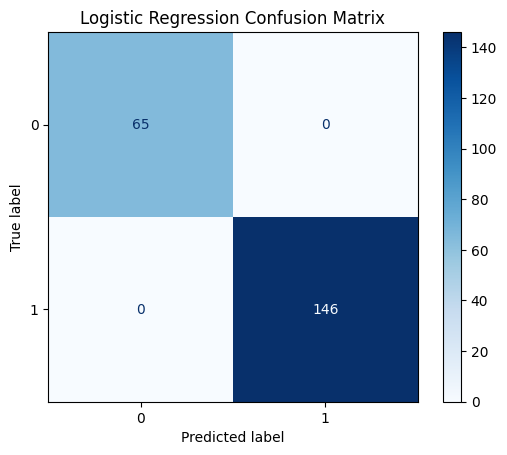


Training SVM...
Cross-validation scores: 0.9751 (+/- 0.0190)

SVM Evaluation:
Accuracy: 0.985781990521327

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        65
           1       0.99      0.99      0.99       146

    accuracy                           0.99       211
   macro avg       0.99      0.98      0.98       211
weighted avg       0.99      0.99      0.99       211

ROC-AUC Score: 0.9993677555321392
Average Precision: 0.9400258511309442


<Figure size 800x600 with 0 Axes>

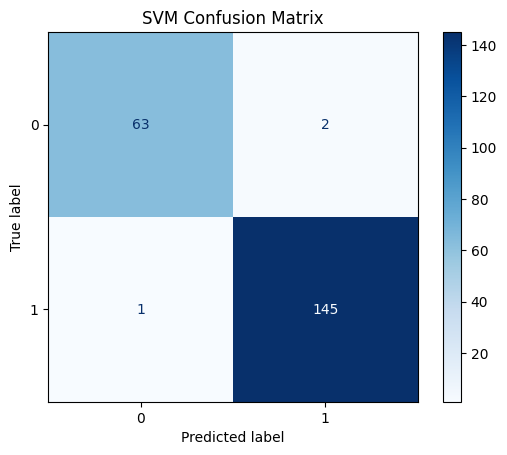


Training Random Forest...
Cross-validation scores: 0.9478 (+/- 0.0311)

Random Forest Evaluation:
Accuracy: 0.9620853080568721

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        65
           1       0.97      0.97      0.97       146

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211

ROC-AUC Score: 0.9940990516332981
Average Precision: 0.9504256478161878


<Figure size 800x600 with 0 Axes>

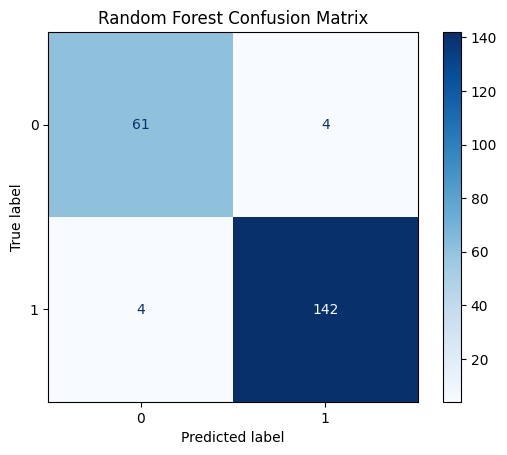


Training K-Nearest Neighbors...
Cross-validation scores: 0.9383 (+/- 0.0118)

K-Nearest Neighbors Evaluation:
Accuracy: 0.957345971563981

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        65
           1       0.99      0.95      0.97       146

    accuracy                           0.96       211
   macro avg       0.94      0.96      0.95       211
weighted avg       0.96      0.96      0.96       211

ROC-AUC Score: 0.9950474183350896
Average Precision: 0.9343506292614515


<Figure size 800x600 with 0 Axes>

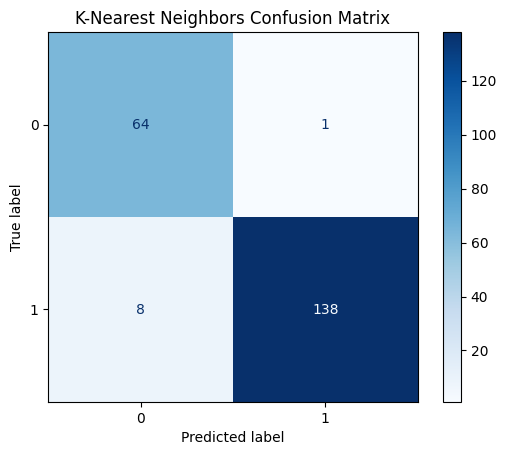


Training Gradient Boosting...
Cross-validation scores: 0.9608 (+/- 0.0096)

Gradient Boosting Evaluation:
Accuracy: 0.981042654028436

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.99      0.98      0.99       146

    accuracy                           0.98       211
   macro avg       0.97      0.98      0.98       211
weighted avg       0.98      0.98      0.98       211

ROC-AUC Score: 0.9984193888303478
Average Precision: 0.9542628413786612


<Figure size 800x600 with 0 Axes>

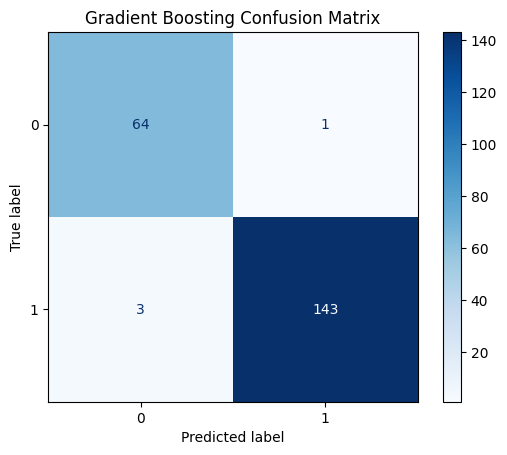


Training AdaBoost...
Cross-validation scores: 0.9988 (+/- 0.0047)

AdaBoost Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       146

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211

ROC-AUC Score: 1.0
Average Precision: 0.9666218257072468


<Figure size 800x600 with 0 Axes>

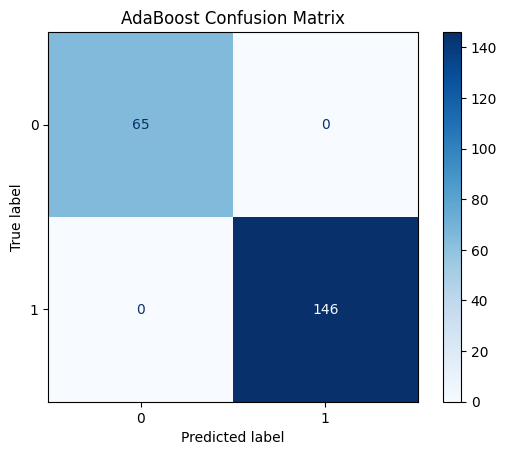


Plotting model comparison...


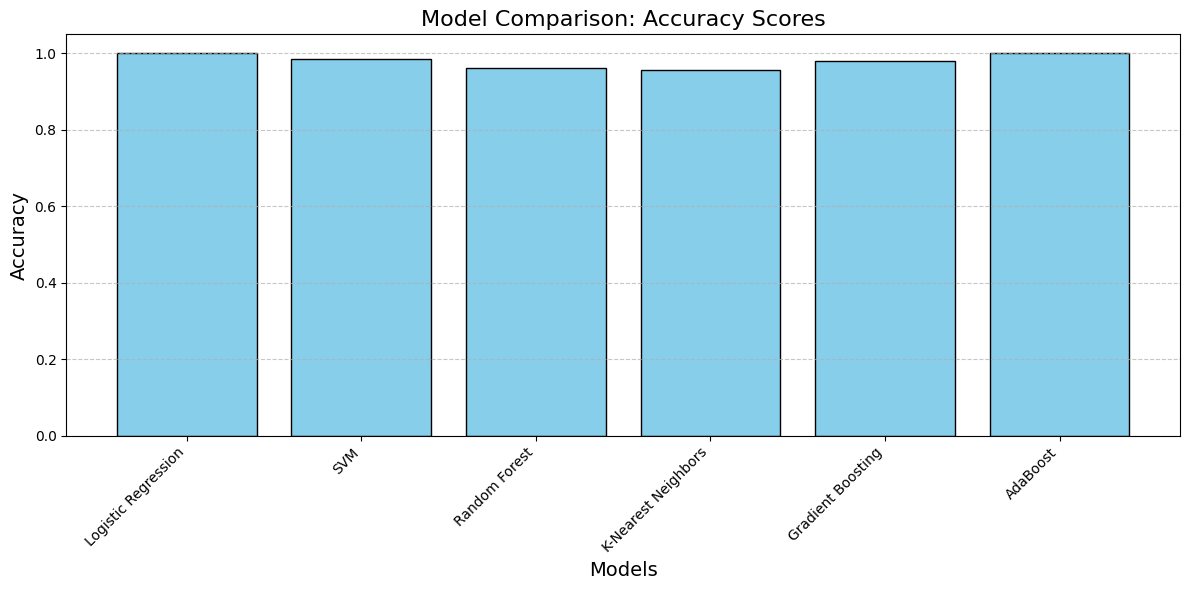


Optimizing AdaBoost model...

Best AdaBoost parameters: {'estimator__max_depth': 1, 'learning_rate': 1.0, 'n_estimators': 100}
Best cross-validation score: 1.0

Evaluating optimized AdaBoost model...

Optimized AdaBoost Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       146

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211

ROC-AUC Score: 1.0
Average Precision: 0.9666794055369232


<Figure size 800x600 with 0 Axes>

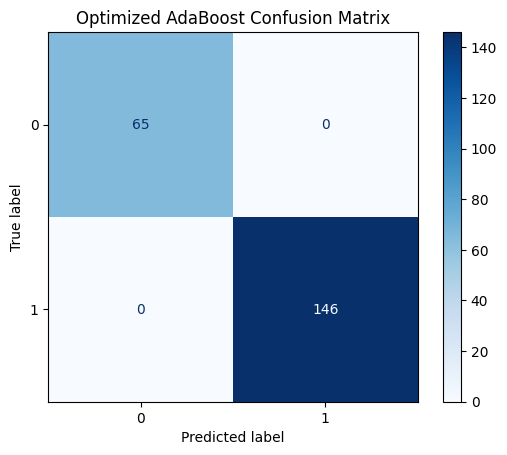


Plotting feature importance for optimized AdaBoost...


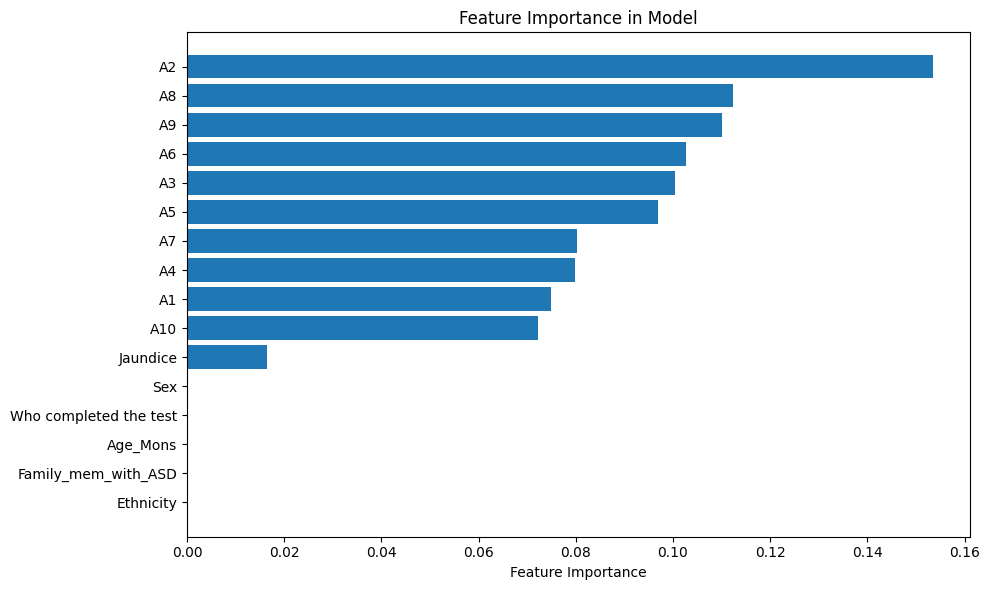

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cb796f378357ea7e8b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [7]:
if __name__ == "__main__":
    # Load and preprocess the dataset
    X, y, label_encoders, scaler, numeric_cols, categorical_cols, df = load_and_preprocess_data()

    # Train the model if target data is available
    if y is not None:
        # Split data into training and testing sets (80% train, 20% test)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        # Train and optimize the model, returning the best AdaBoost model
        model = train_best_model(X_train, X_test, y_train, y_test)
    else:
        model = None  # No model if target is missing

    # Initialize security and privacy managers
    security_manager = SecurityManager()
    privacy_manager = PrivacyManager()

    # Launch the Gradio UI if a model was trained
    if model:
        ui = AutiSenseUI(model, scaler, label_encoders, security_manager, privacy_manager, numeric_cols, categorical_cols)
        gradio_interface = ui.create_interface()  # Create the UI
        gradio_interface.launch(share=True)  # Launch with a shareable link
    else:
        print("Error: Model could not be trained. Check dataset format.")

# Cell 8: Save the Required Files

In [8]:
import joblib

# Save the trained model
joblib.dump(model, "autisense_model.pkl")

# Download the file
from google.colab import files
files.download("autisense_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Download the file
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Save label encoders
joblib.dump(label_encoders, "label_encoders.pkl")

# Download the file
files.download("label_encoders.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>